In [6]:
# 챗봇에 필요한 라이브러리 불러오기

# import langchain and langgraph libs
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_upstage import ChatUpstage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_community.chat_message_histories import ChatMessageHistory

# system prompt
from utils.system_prompt import SYSTEM_PROMPT
from utils.analysis_prompt import ANALYSIS_PROMPT

# others
import os
from dotenv import load_dotenv
import json

# type hint
from typing import TypedDict, List, Dict, Any, Annotated, Optional

# load env
load_dotenv()

True

In [ ]:
# 챗봇에 필요한 랭그래프 상태(state) 구현하기

# define state for chatbot
class ChatbotState(TypedDict):
    # 사용자 정보
    user_id: Annotated[str, "User ID"]
    thread_num: Annotated[str, "Session ID"]
    
    # 대화 정보
    user_message: Annotated[str, "User Message"] # 사용자의 입력 메시지
    chatbot_message: Annotated[str, "Chatbot Message"] # 챗봇의 응답 메시지
    timestamp: Annotated[str, "Timestamp of the conversation"] # 사용자와 챗봇의 응답 시간 기록 값
    chat_history: Annotated[ChatMessageHistory, "chat history of user and ai"] # 처음부터 끝까지의 대화 히스토리
    status: Annotated[str, "Status of the conversation"] # 웹과의 소통 상태 값 (pending, success, error 등)
    
    # 대화 분석 정보
    chat_analysis: Annotated[str, "Analysis of the conversation"] # 대화 내용을 분석한 결과
    retrieved_quotes_and_authors: Annotated[Dict[str, str] | List[tuple[str, str]], "Retrieved 3 quotes and 3 authors from vector db"] # 대화 분석에 적합한 명언과 저자 쌍 3개
    quote: Annotated[str, "Quote for the conversation"] # 최종 선택된 명언
    author: Annotated[str, "Author of the quote"] # 최종 선택된 명언의 저자
    keywords: Annotated[List[str], "Keywords of the conversation"] # 대화 내용 키워드 단어들
    advice: Annotated[str, "Advice for the conversation"] # 대화 분석 결과를 바탕으로 사용자에 적합한 조언

In [8]:
# 웹과 소통할 때 쓰일 사용자의 id와 쓰레드 값

# # identify the user
# def identify_user(state: ChatbotState) -> ChatbotState:
#     return {**state}

# # initialize the session
# def initialize_session(state: ChatbotState) -> ChatbotState:
#     return {**state}

In [ ]:
# 챗봇 그래프에 쓰일 노드 정의하기

# 사용자의 입력 값 검증 -> 챗봇의 응답 생성 -> 대화 히스토리 저장
# 대화 히스토리 분석 -> 끝
# 끝

# 위 순서로 진행된다.


def _init_llm():
    return ChatUpstage(
        model="solar-pro",
        temperature=0.7,
        max_tokens=300,
    )


def validate_user_input(state: ChatbotState) -> ChatbotState:
    user_input = state["user_message"]
    if not isinstance(user_input, str):
        raise TypeError("User message must be a string")
    
    user_input = user_input.strip()
    if not user_input:
        raise ValueError("User message cannot be empty")
        
    if len(user_input) > 150:
        raise ValueError("User message cannot be longer than 150 characters")
    
    return {
        **state,
        "user_message": user_input
    }

def _build_chain():
    llm = _init_llm()
    prompt = ChatPromptTemplate.from_messages([
        ("system", SYSTEM_PROMPT),
        ("user", "{user_input}")
    ])
    chain = prompt | llm  
    return chain


def chatbot(state: ChatbotState) -> ChatbotState:
    # Initialize chat history if empty
    chat_history = state["chat_history"]
    if not chat_history:
        chat_history = ChatMessageHistory()
        
    # Format chat history for prompt if needed
    formatted_history = ""
    if chat_history.messages:
        formatted_history = "\n".join([
            f"{'User' if isinstance(msg, HumanMessage) else 'Assistant'}: {msg.content}"
            for msg in chat_history.messages
        ])
        
    chain = _build_chain()
    response = chain.invoke({
        "user_input": f"{formatted_history}\n\nUser: {state['user_message']}" if formatted_history else state["user_message"]
    })

    return {
        **state,
        "chatbot_message": str(response.content),
    }

def save_history(state: ChatbotState) -> ChatbotState:
    chat_history = state["chat_history"]
    chat_history.add_messages([
        HumanMessage(content=state["user_message"]),
        AIMessage(content=state["chatbot_message"])
    ])

    return {
        **state,
        "chat_history": chat_history 
    }

def _init_analysis_llm():
    return ChatUpstage(
        model="solar-pro",
        temperature=0.7,
    )

def _build_analysis_chain():
    llm = _init_analysis_llm()
    prompt = ChatPromptTemplate.from_messages([
        ("system", ANALYSIS_PROMPT),
        ("user", "다음 대화 히스토리를 분석하라. \\n\\n{chat_history}")
    ])
    chain = prompt | llm
    return chain

def analyze_chat_history(state: ChatbotState) -> ChatbotState:
    chat_history = state["chat_history"]

    # 대화 턴 수가 10턴 이상이면 분석을 한다.
    # 10턴 미만이면 예외를 발생시킨다.
    if len(chat_history.messages) < 10:
        raise ValueError("Chat history must be at least 10 messages")
    
    # 분석 체인을 생성하고 실행한다.
    analysis_chain = _build_analysis_chain()
    analysis_response = analysis_chain.invoke({
        "chat_history": str(chat_history) # 대화 히스토리를 문자열로 변환하여 하나의 텍스트로 전달한다.
    })
    chat_analysis = analysis_response.content
    return {
        **state,
        "chat_analysis": str(chat_analysis)
    }
    
def generate_advice(state: ChatbotState) -> ChatbotState:
    """
    대화 분석을 바탕으로 사용자에 적합한 조언을 생성한다.
    """
    pass

def retrieve_quotes_from_vector_db(state: ChatbotState) -> ChatbotState:
    """
    대화 분석 결과를 바탕으로 명언 벡터 데이터베이스에서 명언 3개를 조회한다.
    """
    pass



def select_quote_from_retrieved_quotes(state: ChatbotState) -> ChatbotState:
    """
    조회된 명언 3개 중 하나를 선택한 뒤, 최종 선택된 명언과 저자, 키워드, 조언을 반환한다.
    """
    pass

In [13]:
# 분기 엣지 정의
def should_analyze_chat_history(state: ChatbotState) -> str:
    if len(state["chat_history"].messages) >= 10:
        return "messages >= 10"
    else:
        return "messages < 10"


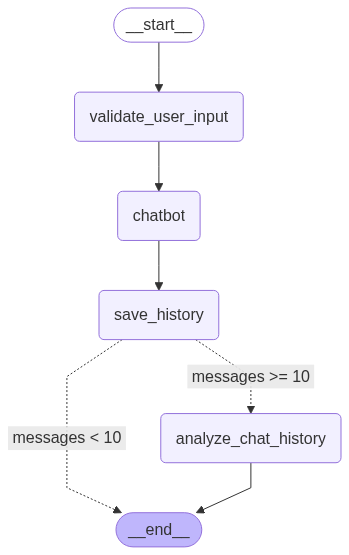

In [14]:
# 위에서 정의한 노드를 연결하여 하나의 그래프를 구성한다.
# 노드와 노드는 엣지로 연결한다.
# 맨 처음과 시작은 START와 END로 연결한다.
# 그래프 구성
workflow = StateGraph(ChatbotState)

# 노드 추가
workflow.add_node("validate_user_input", validate_user_input)
workflow.add_node("chatbot", chatbot)
workflow.add_node("save_history", save_history)
workflow.add_node("analyze_chat_history", analyze_chat_history)

# 엣지 연결
workflow.add_edge(START, "validate_user_input")
workflow.add_edge("validate_user_input", "chatbot")
workflow.add_edge("chatbot", "save_history")

# 조건부 분기 추가
workflow.add_conditional_edges(
    "save_history",
    should_analyze_chat_history,
    path_map={
        "messages >= 10": "analyze_chat_history",
        "messages < 10": END
    }
)

# analyze_chat_history에서 종료로 가는 엣지
workflow.add_edge("analyze_chat_history", END)

# 그래프 컴파일
graph = workflow.compile()
graph

In [ ]:
# 챗봇 그래프를 실행하는 함수이다.
def run_chatbot_once(graph, state, user_input):
    """단일 턴 대화 실행"""
    # 현재 상태에 새로운 사용자 입력 설정
    state["user_message"] = user_input

    # 그래프 실행
    result = graph.invoke(state)

    return result

def print_conversation_result(result, turn_number):
    """대화 결과 출력"""
    print(f"\n=== Turn {turn_number} ===")
    print(f"사용자: {result['user_message']}")
    print(f"챗봇: {result['chatbot_message']}")
    print(f"시간: {result['timestamp']}")
    print(f"유효한 입력: {result['status']}")
    print(f"히스토리 메시지 수: {len(result['chat_history'].messages)}")

def print_chat_history(chat_history):
    """전체 채팅 히스토리 출력"""
    print("\n=== 전체 채팅 히스토리 ===")
    for i, msg in enumerate(chat_history.messages, 1):
        role = "사용자" if msg.type == "human" else "챗봇"
        content = msg.content[:100] + "..." if len(msg.content) > 100 else msg.content
        print(f"{i}. {role}: {content}")

In [ ]:
# 초기 상태 값을 설정한다.
# 대화가 진행되면서 상태 값이 업데이트된다. 이 업데이트된 값을 통해서 웹과 소통할 수 있다.

initial_state = {
    "user_id": "user1",
    "thread_num": "thread1",
    "user_message": "",
    "chatbot_message": "",
    "timestamp": "",
    "chat_history": ChatMessageHistory(),
    "status": "",
    "quote": "",
    "author": "",
    }

In [ ]:
# 멀티턴으로 대화를 실행하는 함수를 정의하여 결과를 보자.
# 사용자가 exit를 입력하면 대화를 종료한다.
import time
def run_multiple_turns(graph, num_turns=10):
    """여러 턴 대화 실행"""
    # 최초 상태 정의
    initial_state = {
        "user_id": "user1",
        "thread_num": "thread1",
        "user_message": "",
        "chatbot_message": "",
        "timestamp": "",
        "chat_history": ChatMessageHistory(),
        "status": "",
        "quote": "",
        "author": "",
    }

    # 대화 실행
    current_state = initial_state
    for i in range(num_turns):
        user_input = input("사용자: ")
        time.sleep(0.2)
        if user_input.lower() == "exit":
            break
        time.sleep(0.2)
        current_state = run_chatbot_once(graph, current_state, user_input)
        print_conversation_result(current_state, i + 1)
        print_chat_history(current_state["chat_history"])
    return current_state    

In [ ]:
run_multiple_turns(graph, num_turns=10)


=== Turn 1 ===
사용자: 안녕
챗봇: 안녕! 오랜만이네. 어떻게 지냈어? 최근에 재미있는 일 있었어?
시간: 
유효한 입력: 
히스토리 메시지 수: 2

=== 전체 채팅 히스토리 ===
1. 사용자: 안녕
2. 챗봇: 안녕! 오랜만이네. 어떻게 지냈어? 최근에 재미있는 일 있었어?

=== Turn 2 ===
사용자: 그래
챗봇: 그래, 최근에 별일 없었어? 나도 시간이 날 때마다 책 읽고, 산책하는 게 좀 재미있더라. 너도 어떤 취미 생활 해?
시간: 
유효한 입력: 
히스토리 메시지 수: 4

=== 전체 채팅 히스토리 ===
1. 사용자: 안녕
2. 챗봇: 안녕! 오랜만이네. 어떻게 지냈어? 최근에 재미있는 일 있었어?
3. 사용자: 그래
4. 챗봇: 그래, 최근에 별일 없었어? 나도 시간이 날 때마다 책 읽고, 산책하는 게 좀 재미있더라. 너도 어떤 취미 생활 해?


{'user_id': 'user1',
 'thread_num': 'thread1',
 'user_message': '그래',
 'chatbot_message': '그래, 최근에 별일 없었어? 나도 시간이 날 때마다 책 읽고, 산책하는 게 좀 재미있더라. 너도 어떤 취미 생활 해?',
 'timestamp': '',
 'chat_history': InMemoryChatMessageHistory(messages=[HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}), AIMessage(content='안녕! 오랜만이네. 어떻게 지냈어? 최근에 재미있는 일 있었어?', additional_kwargs={}, response_metadata={}), HumanMessage(content='그래', additional_kwargs={}, response_metadata={}), AIMessage(content='그래, 최근에 별일 없었어? 나도 시간이 날 때마다 책 읽고, 산책하는 게 좀 재미있더라. 너도 어떤 취미 생활 해?', additional_kwargs={}, response_metadata={})]),
 'status': '',
 'quote': '',
 'author': ''}